### Exploration of results

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Source plotting functions
from functions.plotting import signal_shares_lineplot_quarters, signal_shares_lineplot_yearlymean, plot_signal_shares_per_sector, signal_shares_lineplot_per_sector

In [2]:
# Read in CIK as string, so that leading zeros are preserved
analyst_ratings = pd.read_csv("../data/sp1500_sell_side_recommendations_ffilled.csv", dtype={"cik": str})

# LLM recommendations with only most recent financial statements
llm_recommendations = pd.read_csv("../data/llm_recommendations_final.csv", dtype={"cik": str})

# Convert date to period format
llm_recommendations["date"] = pd.to_datetime(llm_recommendations["date"]).dt.to_period("M").astype(str)
analyst_ratings["date"] = pd.to_datetime(analyst_ratings["date"]).dt.to_period("M").astype(str)

# Drop duplicates
llm_recommendations.drop_duplicates(subset=["cik", "date"], inplace=True)
analyst_ratings.drop_duplicates(subset=["cik", "date"], inplace=True)

# Read in df with info on economic sectors
sectors = pd.read_csv("../data/sp1500_market_sectors.csv", dtype={"cik": str})
sectors = sectors.drop_duplicates(subset=["cik"])

len(llm_recommendations), len(analyst_ratings)

(120860, 355218)

In [3]:
# Subsetting unique CIK and date combinations from both datasets
llm_ciks_and_dates = llm_recommendations[["cik", "date"]].drop_duplicates()
analyst_ciks_and_dates = analyst_ratings[["cik", "date"]].drop_duplicates() 

# Determine overlap through merge
shared_ciks_and_dates = pd.merge(llm_ciks_and_dates, analyst_ciks_and_dates, on=["cik", "date"], how="inner")

# Only keep CIK date combinations that are in both datasets
llm_recommendations_final = pd.merge(
    llm_recommendations, shared_ciks_and_dates, on=["cik", "date"], how="inner"
)
analyst_ratings_final = pd.merge(
    analyst_ratings, shared_ciks_and_dates, on=["cik", "date"], how="inner"
)
len(llm_recommendations_final), len(analyst_ratings_final)

(113301, 113301)

In [4]:
llm_df = llm_recommendations_final.merge(sectors, on="cik", how="inner")
analyst_df = analyst_ratings_final.merge(sectors, on="cik", how="left")
len(llm_df), len(analyst_df)

(113301, 113301)

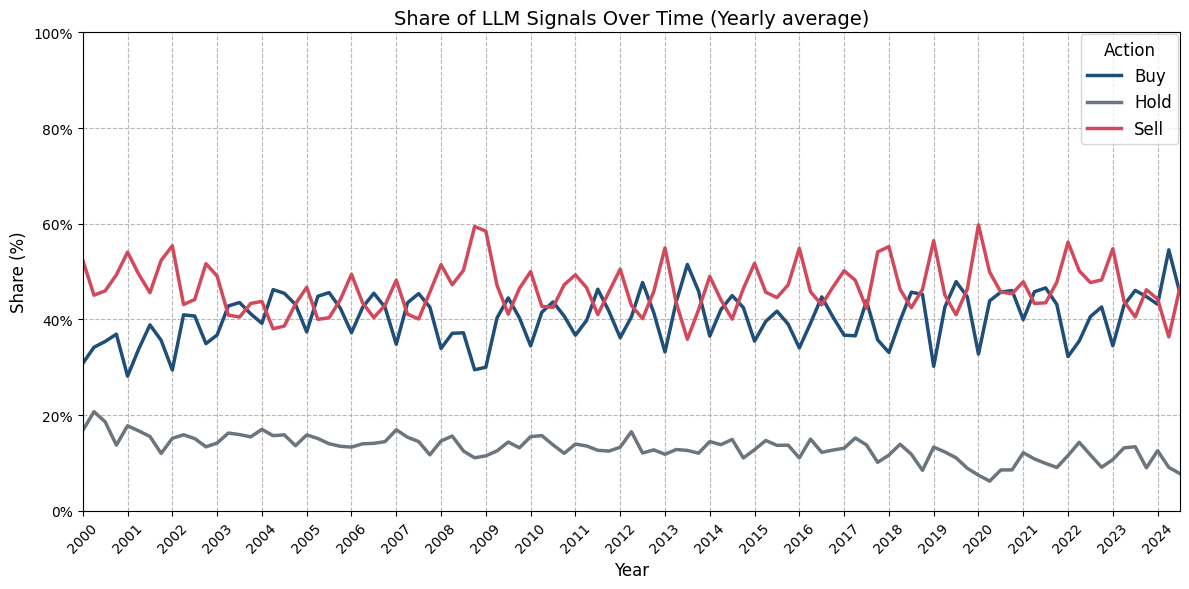

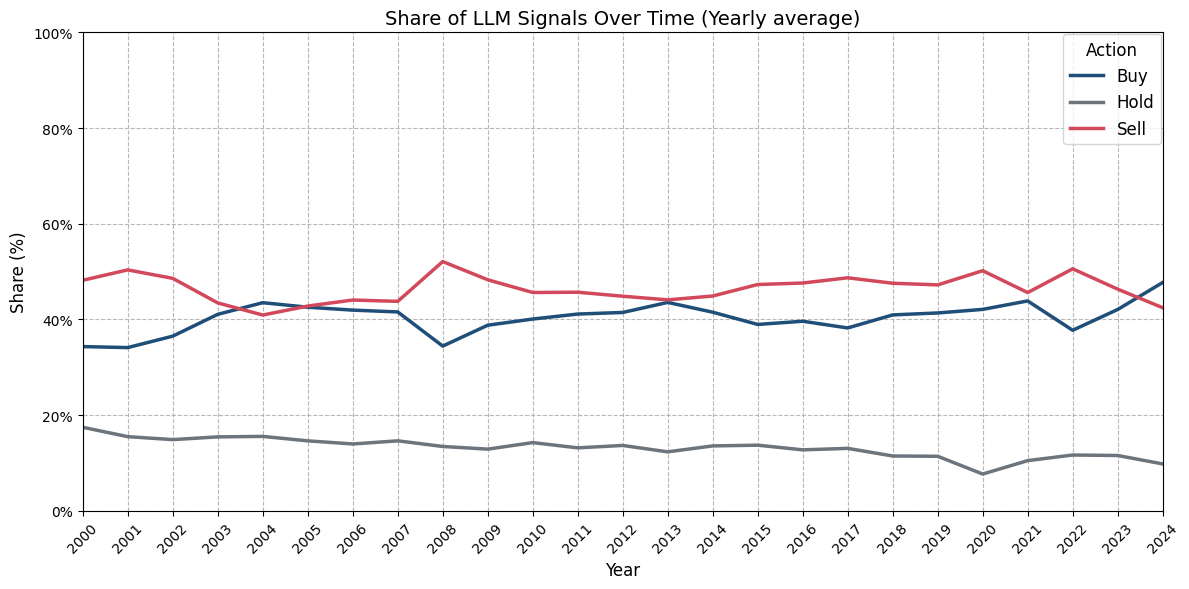

(None, None)

In [5]:
signal_shares_lineplot_quarters(llm_df), signal_shares_lineplot_yearlymean(llm_df)

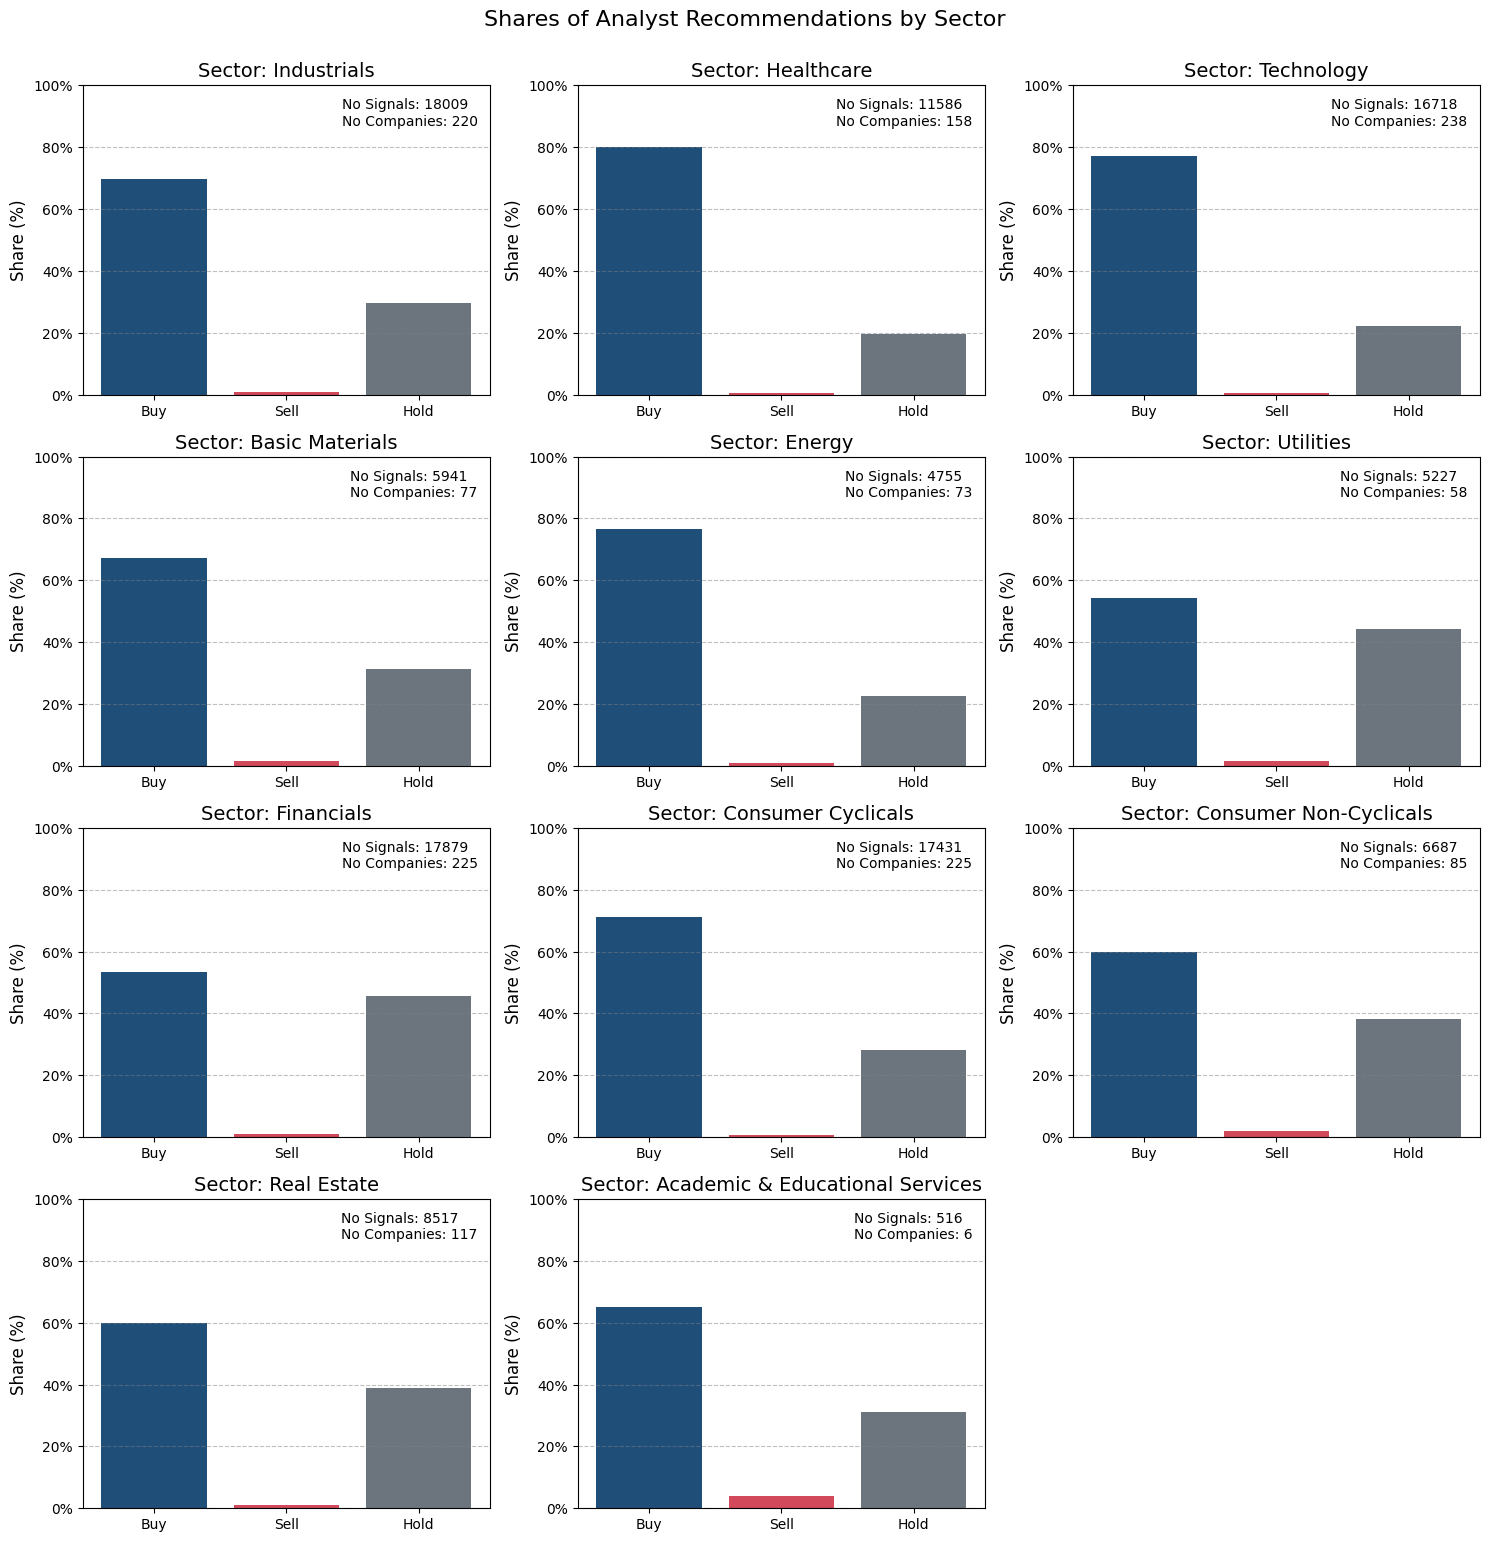

In [6]:
plot_signal_shares_per_sector(analyst_df, llm_indicator = False)

# include number of companies per sector

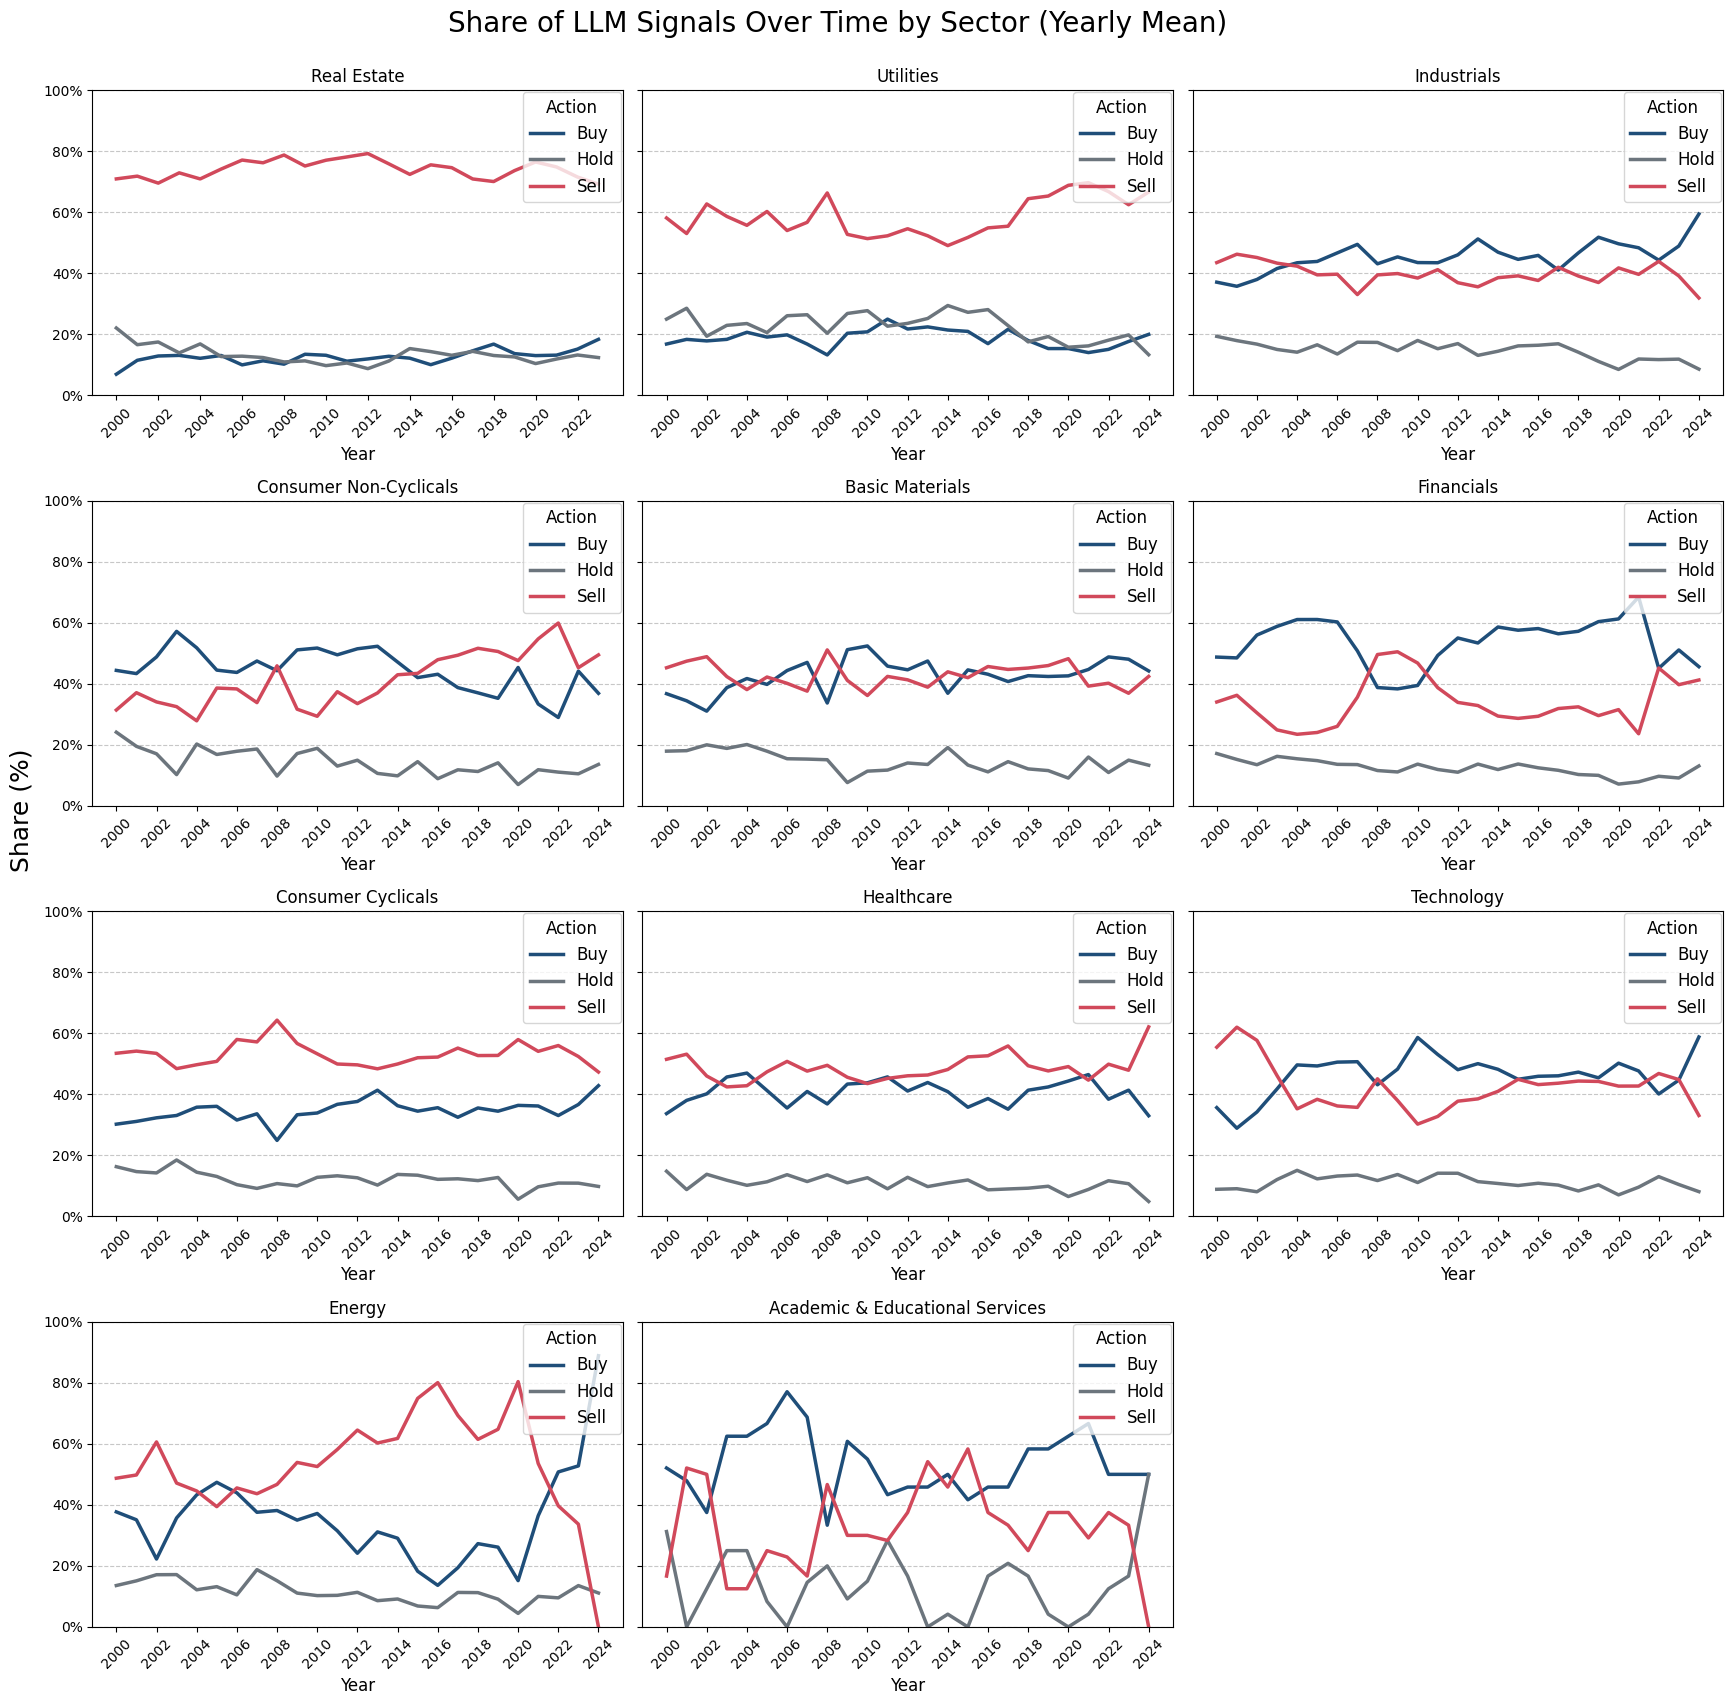

In [7]:
signal_shares_lineplot_per_sector(llm_df, llm_indicator = True)

- Inspection of signal "switches", i.e. how often do analysts/LLMs change their recommendation from their previous one. Is there an anchoring bias?

In [26]:
def count_signal_switches(recommendations_df):
    switches_df = pd.DataFrame(columns=["cik", "n_switches"])
    for cik in recommendations_df["cik"].unique():
        # Subset recommendations for 1 company and sort by date (again, to be safe)
        signals = recommendations_df[recommendations_df["cik"] == cik].sort_values(by="date")[["action", "date", "cik"]].values
        # Count number of switches
        switches = np.sum(signals[1:, 0] != signals[:-1, 0]) 
        # 1: selects everything but the first entry, :-1 everything but the last entry. This effectively shifts the array by one position, allowing for pairwise comparison of consecutive elements.
        # Append to df
        switches_df = pd.concat([switches_df, pd.DataFrame({"cik": [cik], "n_switches": [switches]})], ignore_index=True)
    return switches_df

In [34]:
analyst_switches = count_signal_switches(analyst_df)
llm_switches = count_signal_switches(llm_df)

LLM signals change 4.58 times as often as analyst signals.


In [40]:
analyst_switches["n_switches"].sum(), llm_switches["n_switches"].sum()
print(f"From a total of {len(llm_df)} signals, the LLM changed its recommendation {llm_switches['n_switches'].sum()} times ({(llm_switches['n_switches'].sum() / len(llm_df) * 100):.2f}%), while analysts changed their recommendation {analyst_switches['n_switches'].sum()} times ({(analyst_switches['n_switches'].sum() / len(analyst_df) * 100):.2f}%).")
print(f"LLM signals change {llm_switches['n_switches'].sum() / analyst_switches['n_switches'].sum():.2f} times as often as analyst signals.")
print(f"On average, analysts change their recommendation {analyst_switches['n_switches'].mean():.2f} times, while LLMs change their recommendation {llm_switches['n_switches'].mean():.2f} times.")

From a total of 113301 signals, the LLM changed its recommendation 51958 times (45.86%), while analysts changed their recommendation 11342 times (10.01%).
LLM signals change 4.58 times as often as analyst signals.
On average, analysts change their recommendation 7.65 times, while LLMs change their recommendation 35.04 times.
